## Load Data

In [1]:
from scripts.preprocess_data import *
# Load, clean and normalize the df
df = load_data("dataset.json")
df = clean_data(df)
df = normalize_data(df)


In [2]:
import pandas as pd

relations = pd.read_csv("graph.csv")

## Build Graph and Compute Neigbhors

In [3]:
import networkx as nx

# Build graph
G = nx.from_pandas_edgelist(relations, source='source', target='target')

# Precompute neighbors
neighbors = {node: set(G.neighbors(node)) for node in G.nodes}

## Co-citation

In [126]:
import matplotlib.pyplot as plt

# Co-Citation Optimization
co_citation = {node: {n: len(neighbors[node] & neighbors[n]) for n in neighbors[node]} for node in G.nodes}


# Filter for high co-citation values
threshold = 1
subgraph_edges = [
    (node, target, weight) for node, connections in co_citation.items()
    for target, weight in connections.items() if weight >= threshold
]

# Create a subgraph
H = nx.Graph()
H.add_weighted_edges_from(subgraph_edges)

# Visualize subgraph

edge_labels = nx.get_edge_attributes(H, 'weight')
pos = nx.spring_layout(H)


KeyboardInterrupt: 

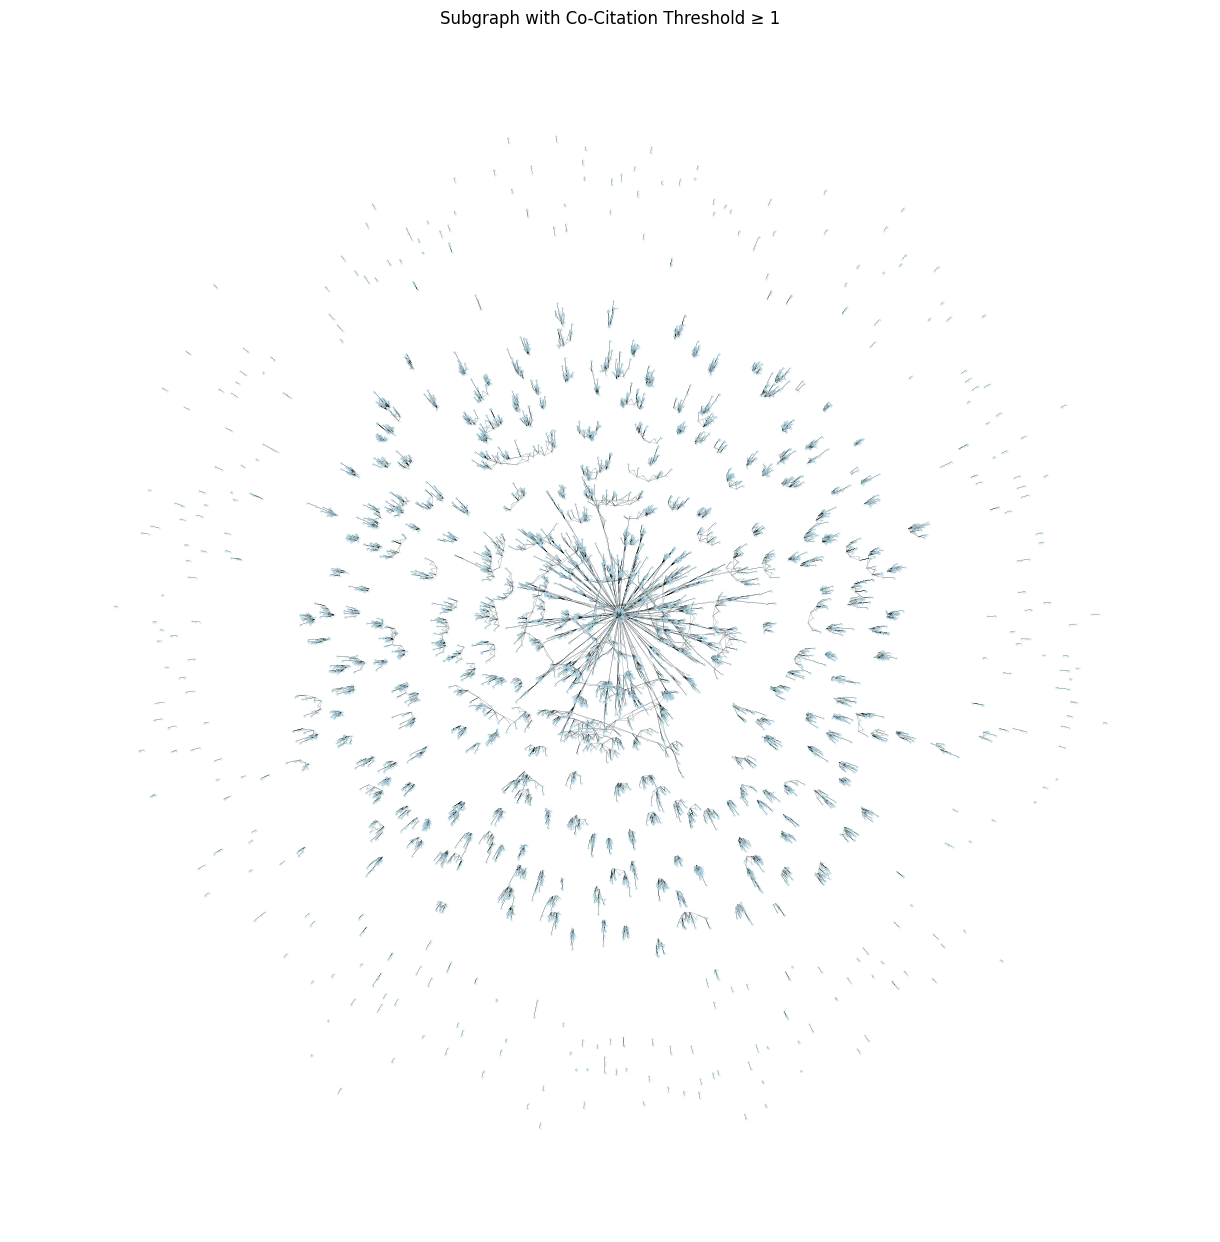

In [110]:

plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=False, node_size=0.1, width=0.1,node_color='lightblue')
plt.title(f"Subgraph with Co-Citation Threshold ≥ {threshold}")
plt.show()

In [150]:
import pandas as pd

# Determine the maximum co-citation value
max_co_citation = max(
    weight for connections in co_citation.values()
    for weight in connections.values()
)

# Create a summary table for the number of edges at each threshold, including threshold 0
threshold_summary = []
for threshold in range(0, max_co_citation + 2):
    filtered_edges = [
        (node, target, weight) for node, connections in co_citation.items()
        for target, weight in connections.items() if weight >= threshold
    ]
    # Count unique nodes in the filtered edges
    unique_nodes = set(node for edge in filtered_edges for node in edge[:2])
    threshold_summary.append({
        "Threshold": threshold,
        "Number of Edges": len(filtered_edges),
        "Number of Nodes": len(unique_nodes),
    })

# Convert to a DataFrame for tabular display
df_summary = pd.DataFrame(threshold_summary)

# Display the table
print(df_summary)

    Threshold  Number of Edges  Number of Nodes
0           0           189768            46849
1           1            46700            13776
2           2             7980             3894
3           3             2822             1718
4           4             1138              848
5           5              548              466
6           6              280              257
7           7              120              115
8           8               52               50
9           9               30               29
10         10                6                6
11         11                4                4
12         12                2                2
13         13                0                0


## Bibliographic Coupling

In [156]:
import networkx as nx
import matplotlib.pyplot as plt

bibliographic_coupling = {node: {n: len(set(G.neighbors(node)) & set(G.neighbors(n))) for n in G.neighbors(node)} for node in G.nodes}

threshold = 1

# Filter bibliographic coupling based on the threshold
filtered_bibliographic_coupling = {
    node: {n: count for n, count in couplings.items() if count >= threshold}
    for node, couplings in bibliographic_coupling.items()
}

# Create an undirected graph
UG = nx.Graph()

# Add nodes and edges with filtered coupling values
for node, couplings in filtered_bibliographic_coupling.items():
    for n, weight in couplings.items():
        UG.add_edge(node, n, weight=weight)

# Visualization
pos = nx.spring_layout(UG)


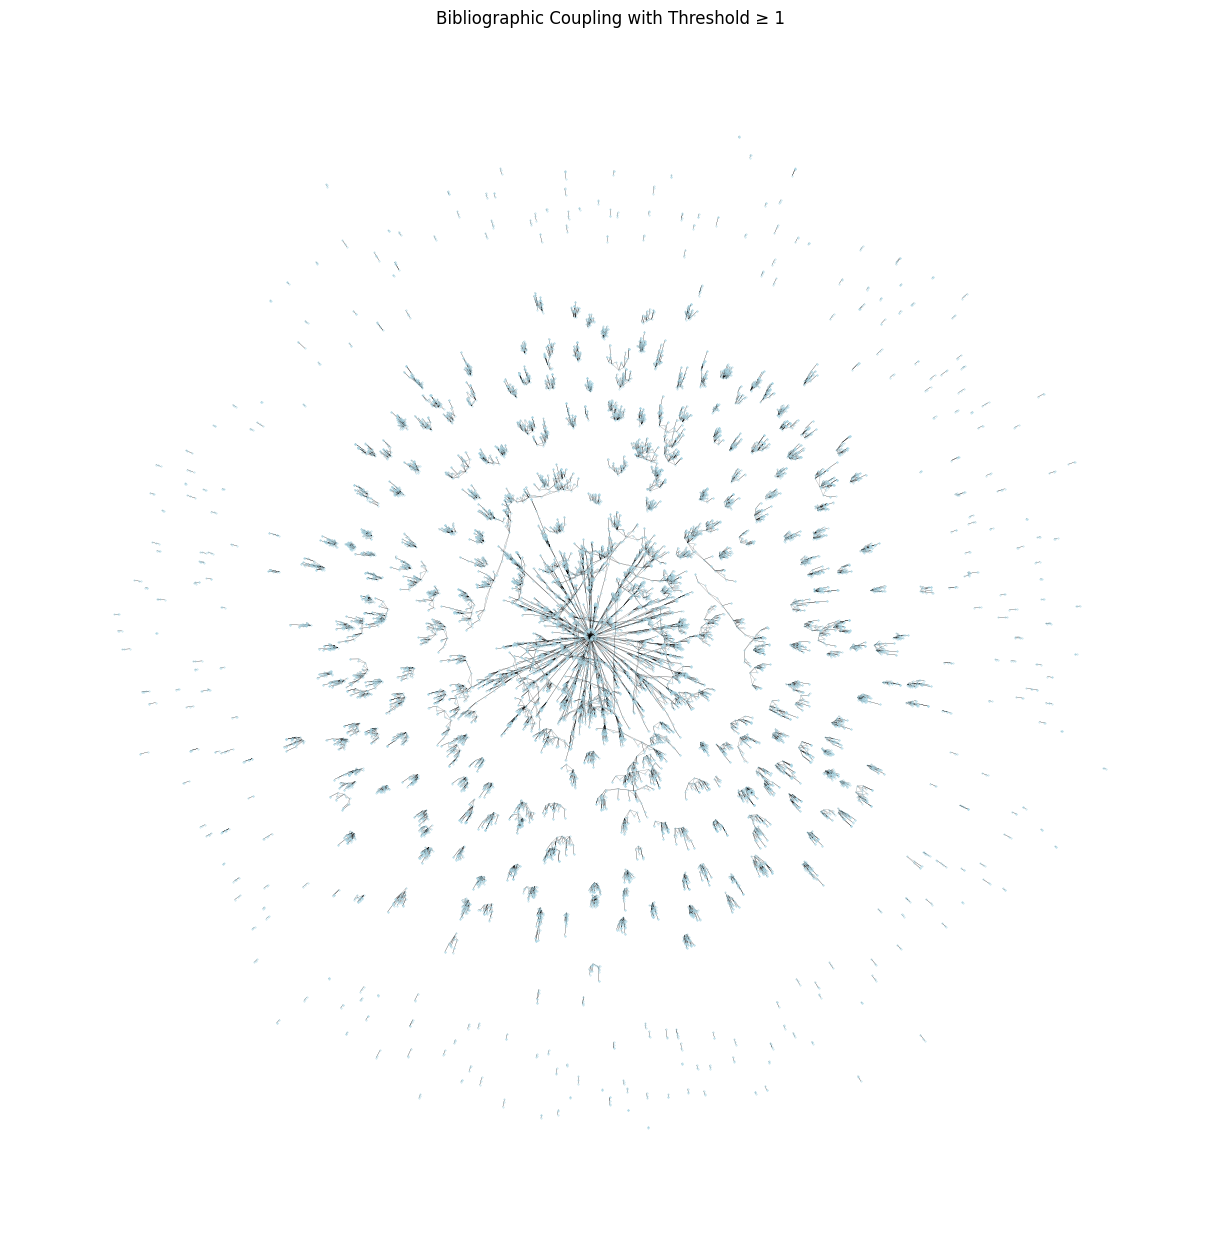

In [157]:
plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=False, node_size=0.1, width=0.1,node_color='lightblue')
plt.title(f"Bibliographic Coupling with Threshold ≥ {threshold}")
plt.show()

In [158]:
import networkx as nx
import pandas as pd

max_threshold = 12

# Create an empty dictionary to store nodes and edges count
results = {}

# Iterate over thresholds from 1 to max_threshold
for threshold in range(1, max_threshold + 2):
    filtered_bibliographic_coupling = {
        node: {n: count for n, count in couplings.items() if count >= threshold}
        for node, couplings in bibliographic_coupling.items()
    }

    # Create an undirected graph for each threshold
    UG = nx.Graph()

    # Add nodes and edges with filtered coupling values
    for node, couplings in filtered_bibliographic_coupling.items():
        for n, weight in couplings.items():
            UG.add_edge(node, n, weight=weight)

    # Get the number of nodes and edges
    num_nodes = UG.number_of_nodes()
    num_edges = UG.number_of_edges()

    # Store results in a dictionary
    results[threshold] = (num_nodes, num_edges)

# Convert the results to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Number of Nodes', 'Number of Edges'])

# Print the DataFrame as a table
print(df_results)


    Number of Nodes  Number of Edges
1             13776            23350
2              3894             3990
3              1718             1411
4               848              569
5               466              274
6               257              140
7               115               60
8                50               26
9                29               15
10                6                3
11                4                2
12                2                1
13                0                0


## Cycles & Acyclic Networks

In [10]:
cycles = list(nx.simple_cycles(G)) # Takes too long
print("Cycles:", cycles)

Acyclic: False


KeyboardInterrupt: 

## Hypergraphs

In [73]:
import hypernetx as hnx
import matplotlib.pyplot as plt

hyper_edges = relations.groupby('source')['target'].apply(list).to_dict()

# Create the initial hypergraph
H = hnx.Hypergraph(hyper_edges)

# Filter nodes with degree greater than a threshold
threshold = 4
filtered_edges = {node: edges for node, edges in hyper_edges.items() if node in H.nodes and H.degree(node) >= threshold}

# Create a new Hypergraph with the filtered nodes and edges
subset_H = hnx.Hypergraph(filtered_edges)

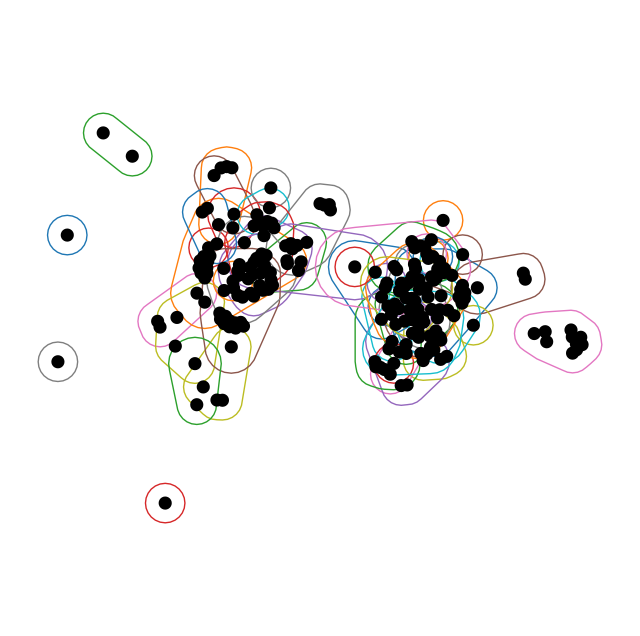

In [79]:
hnx.draw(subset_H,with_node_labels=False, with_edge_labels=False)

plt.show()

In [75]:
# Function to calculate the number of nodes and edges for a given threshold
def get_elements_for_threshold(threshold):
    # Ensure the nodes exist in the hypergraph
    filtered_edges = {node: edges for node, edges in hyper_edges.items() if node in H.nodes and H.degree(node) > threshold}
    subset_H = hnx.Hypergraph(filtered_edges)
    num_nodes = len(subset_H.nodes)
    num_edges = len(subset_H.edges)
    return num_nodes, num_edges

# Output the results for different thresholds
print(f"Threshold | Number of Nodes | Number of Hyperedges")
print("-" * 40)

for threshold in range(8):
    num_nodes, num_edges = get_elements_for_threshold(threshold)
    print(f"{threshold:8} | {num_nodes:14} | {num_edges:12}")

Threshold | Number of Nodes | Number of Hyperedges
----------------------------------------
       0 |          45827 |        24666
       1 |          44118 |        23983
       2 |            890 |          315
       3 |            209 |           54
       4 |            117 |           23
       5 |             39 |            8
       6 |             30 |            3
       7 |              0 |            0


## Degree and Density

In [29]:
degree = dict(G.degree())
density = nx.density(G)
print(degree)
print(density)

{1084949174: 46, 1050463558: 12, 1002148361: 12, 1000741574: 24, 1019020642: 16, 1044910984: 5, 1032965820: 10, 1045532631: 3, 1062570867: 4, 1093616433: 2, 1046494658: 4, 1071753837: 16, 1005890294: 9, 1088712592: 4, 1087450175: 11, 1059839736: 6, 1069823047: 3, 1026118838: 3, 1073919686: 5, 1060428001: 3, 1050607585: 2, 1001691761: 3, 1070498956: 4, 1071870955: 4, 1035595201: 3, 1051971605: 5, 1015062812: 3, 1034483550: 2, 1029385317: 3, 1038596028: 3, 1051729820: 3, 1004123432: 2, 1012378934: 3, 1079898450: 2, 1063959866: 2, 1054238235: 2, 1082653249: 5, 1061759881: 2, 1072398557: 3, 1045545909: 3, 1040044735: 2, 1051921689: 2, 1068393016: 2, 1039859493: 2, 1014561778: 2, 1030635339: 2, 1006065364: 3, 1016676496: 3, 1007172640: 7, 1058107871: 2, 1026240394: 3, 1048513307: 4, 1078326898: 11, 1074771837: 3, 1000373575: 2, 1044442132: 3, 1006398548: 4, 1054723108: 7, 1034569772: 4, 1014333778: 3, 1057217762: 2, 1073773347: 2, 1077572316: 3, 1063635847: 4, 1083119109: 8, 1029403491: 7, 

# Base Calculation for Measures

In [62]:
import networkx as nx
sample_size = 6000 # maybe later all
G_sampled = G.subgraph(list(G.nodes())[:sample_size])
pos = nx.spring_layout(G_sampled)  # positions for all nodes

## Centrality Measures

In [30]:
degree_centrality = nx.degree_centrality(G_sampled)
print("Degree Centrality:", degree_centrality)

Degree Centrality: {1043095555: 0.0006668889629876625, 1060446214: 0.0006668889629876625, 1018716167: 0.0010003334444814937, 1004421129: 0.001333777925975325, 1098801161: 0.0010003334444814937, 1053122571: 0.0006668889629876625, 1033371660: 0.0006668889629876625, 1065664526: 0.0006668889629876625, 1061068817: 0.0006668889629876625, 1099374610: 0.0006668889629876625, 1052516369: 0.0006668889629876625, 1080074262: 0.0010003334444814937, 1005436950: 0.0010003334444814937, 1054973977: 0.0016672224074691564, 1031847962: 0.0006668889629876625, 1066483739: 0.0023341113704568187, 1070661660: 0.0023341113704568187, 1093263385: 0.0006668889629876625, 1041842208: 0.0006668889629876625, 1099964448: 0.0020006668889629873, 1078992933: 0.008669556518839612, 1011130406: 0.0010003334444814937, 1081761831: 0.0006668889629876625, 1050861607: 0.0006668889629876625, 1045938217: 0.004668222740913637, 1039335469: 0.0006668889629876625, 1081090093: 0.0010003334444814937, 1002733615: 0.0006668889629876625, 104

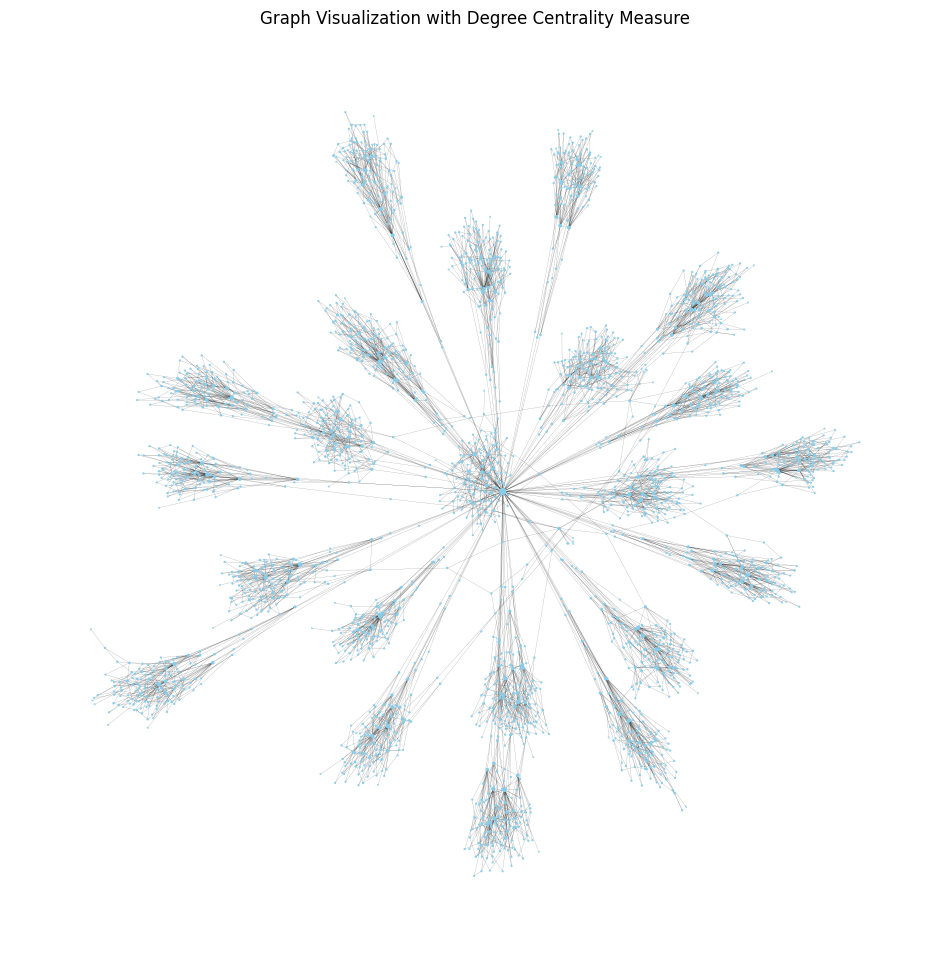

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in degree_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with Degree Centrality Measure")

# Display
plt.axis('off')
plt.show()

In [34]:
eigenvector_centrality = nx.eigenvector_centrality(G_sampled, max_iter=200)
print("Eigenvector Centrality:", eigenvector_centrality)

Eigenvector Centrality: {1043095555: 0.00014362515027184646, 1060446214: 0.00018897300870469787, 1018716167: 0.0011894043287888013, 1004421129: 0.0009862608612115108, 1098801161: 0.0017212000629894168, 1053122571: 0.00017178335363371403, 1033371660: 0.00017353744812796172, 1065664526: 0.000857308569161198, 1061068817: 0.0014673694222957113, 1099374610: 0.00028390994036275684, 1052516369: 0.0004008841538491437, 1080074262: 0.00022323874745213768, 1005436950: 0.0006919123436547684, 1054973977: 0.0018978857361794358, 1031847962: 0.0003427314166174918, 1066483739: 0.0019666889207210175, 1070661660: 0.0004670174278833984, 1093263385: 0.00012260321644347815, 1041842208: 0.0019590970522686906, 1099964448: 0.000731783863590929, 1078992933: 0.008789165337713758, 1011130406: 0.0033325875252257376, 1081761831: 0.0015098078914357717, 1050861607: 0.0007918687475462461, 1045938217: 0.004791716009359036, 1039335469: 0.0013108238508045772, 1081090093: 0.0018108388778465723, 1002733615: 0.0064996136415

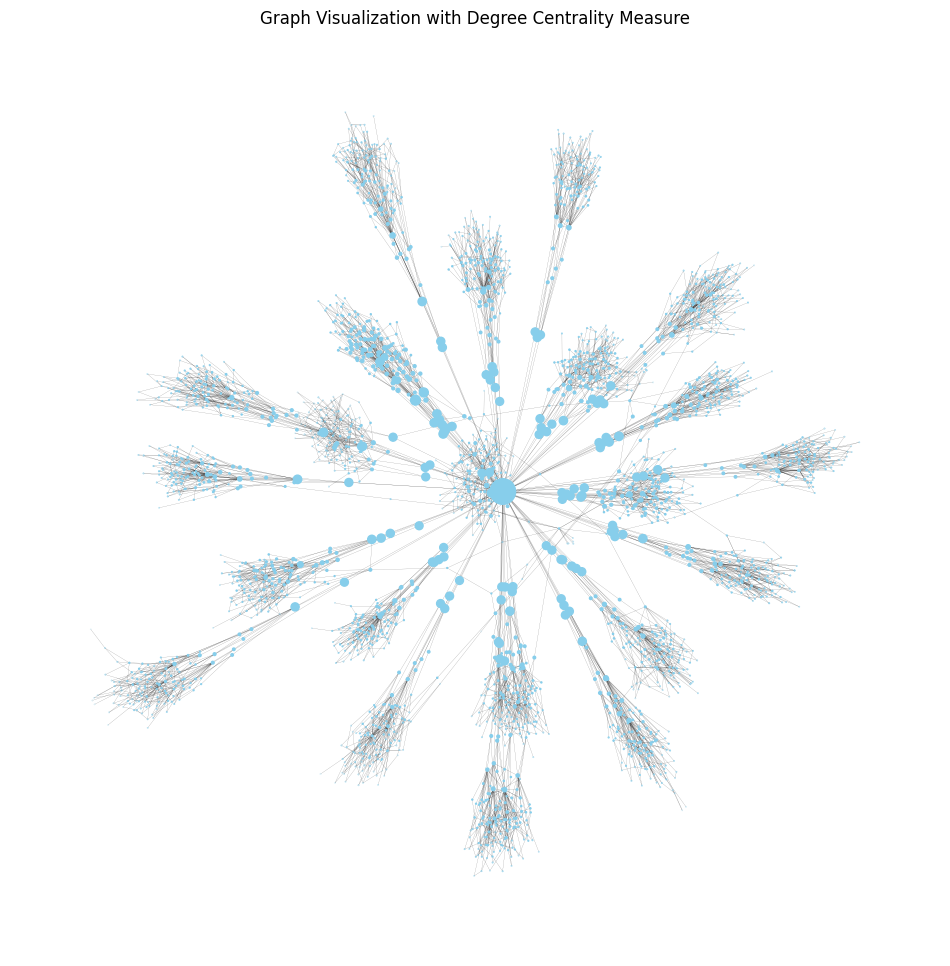

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in eigenvector_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with Eigenvector Centrality Measure")

# Display
plt.axis('off')
plt.show()

In [36]:
# katz_centrality = nx.katz_centrality(G, alpha=0.5, beta=1.0, max_iter=4000) # Takes too long
pagerank = nx.pagerank(G_sampled)
#print("Katz Centrality:", katz_centrality)
print("PageRank:", pagerank)


PageRank: {1043095555: 0.00020202470152504455, 1060446214: 0.0001911320368912122, 1018716167: 0.00026352433265949355, 1004421129: 0.0003382010327309695, 1098801161: 0.0002684233643330709, 1053122571: 0.00019205142702190665, 1033371660: 0.00019948976150733797, 1065664526: 0.00019237795185002353, 1061068817: 0.00018051140648950436, 1099374610: 0.0001832461295306299, 1052516369: 0.00019635807255157658, 1080074262: 0.00025648601800526904, 1005436950: 0.0002645877857458793, 1054973977: 0.00042048960570729006, 1031847962: 0.0001869005961759092, 1066483739: 0.0005522893204991881, 1070661660: 0.0005809522837573973, 1093263385: 0.0002072781630230546, 1041842208: 0.0001841804006148751, 1099964448: 0.0004953937100640118, 1078992933: 0.0019375227245692424, 1011130406: 0.00025178795536270643, 1081761831: 0.00017760508018423537, 1050861607: 0.0001859100011651192, 1045938217: 0.0010277350339123641, 1039335469: 0.0001827283630828237, 1081090093: 0.00026295780533688997, 1002733615: 0.000185687427188242

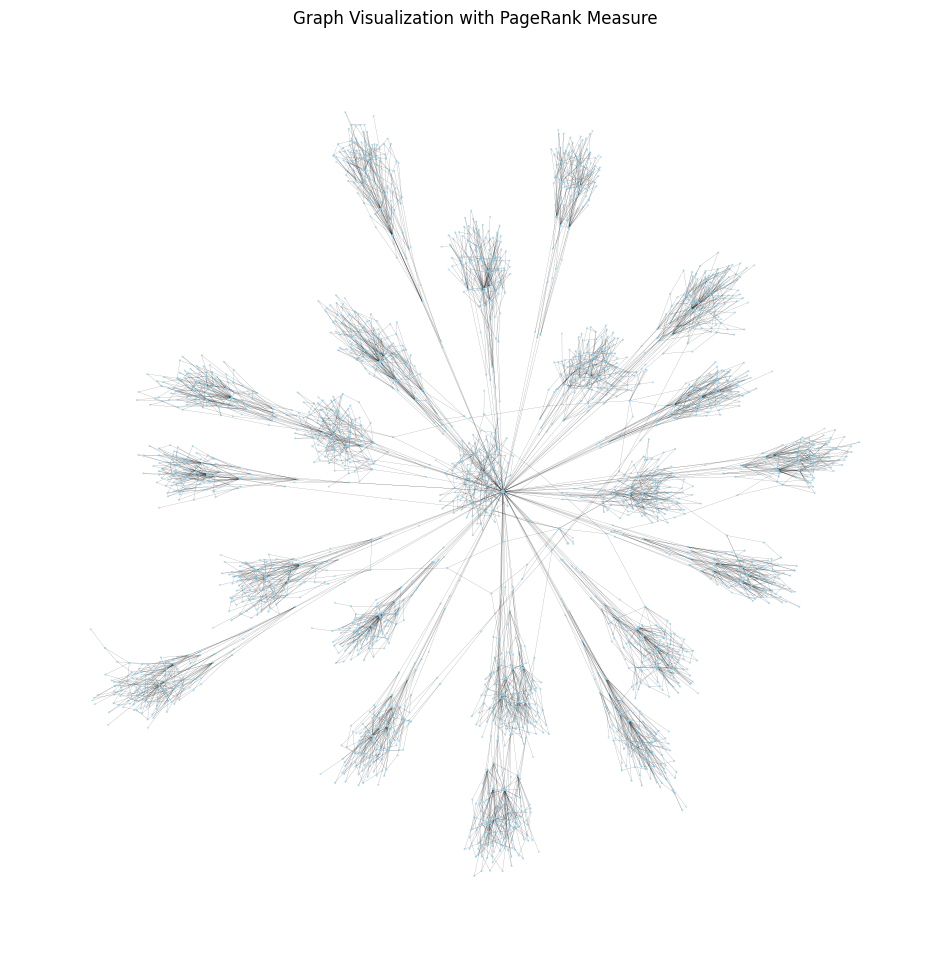

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in pagerank.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

In [38]:
closeness_centrality = nx.closeness_centrality(G_sampled)
print("Closeness Centrality:", closeness_centrality)

Closeness Centrality: {1043095555: 0.14008127423046382, 1060446214: 0.1398395971276695, 1018716167: 0.16236262248930755, 1004421129: 0.14095032194388307, 1098801161: 0.16211687118222606, 1053122571: 0.13995706552174725, 1033371660: 0.12394610679451148, 1065664526: 0.16185439041502508, 1061068817: 0.16319312183707896, 1099374610: 0.1401532853537714, 1052516369: 0.1400747314339094, 1080074262: 0.12424393073162648, 1005436950: 0.14135558069381599, 1054973977: 0.16192430214351278, 1031847962: 0.14110285122800414, 1066483739: 0.16354018976987675, 1070661660: 0.14058691168198012, 1093263385: 0.13953380170288002, 1041842208: 0.16314873245566314, 1099964448: 0.14048812479505318, 1078992933: 0.1633887224189594, 1011130406: 0.1630068485704968, 1081761831: 0.1412490580256217, 1050861607: 0.1625033866160932, 1045938217: 0.1639245695545231, 1039335469: 0.16265321618396789, 1081090093: 0.1629891304347826, 1002733615: 0.19150702426564495, 1049419824: 0.19328435163701985, 1058906160: 0.140567143191938

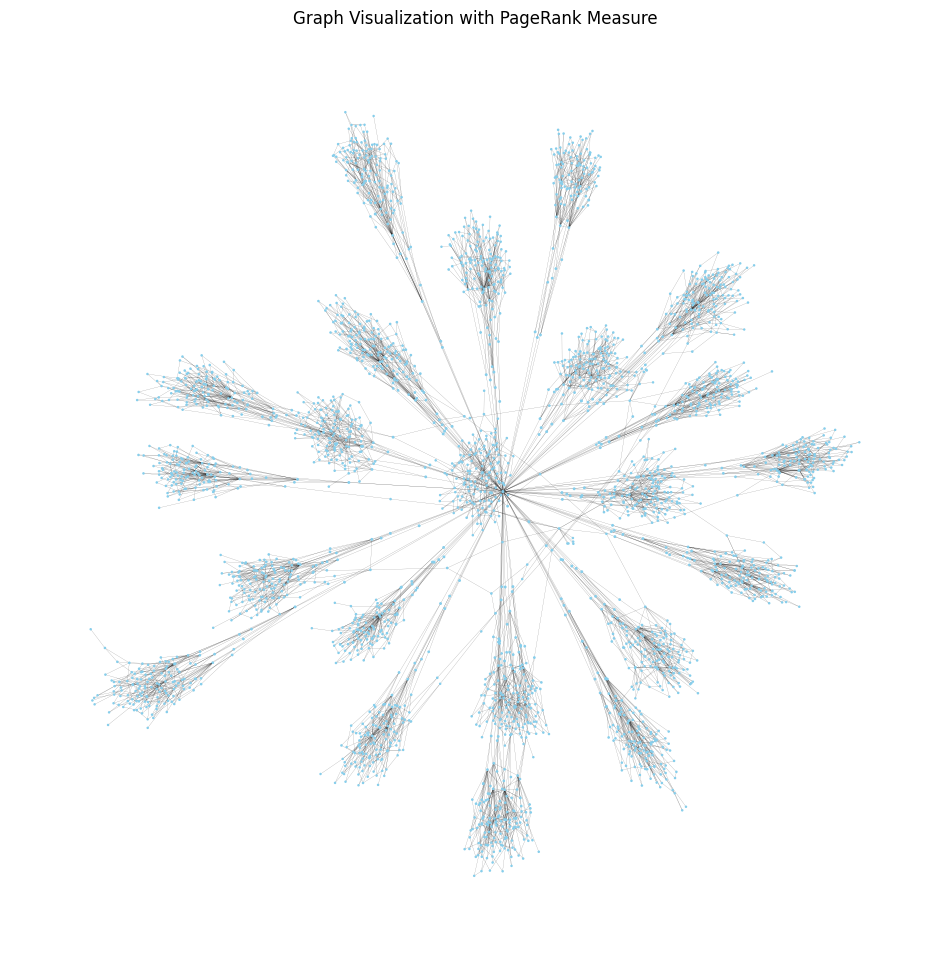

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 5 for v in closeness_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

In [42]:
betweenness_centrality = nx.betweenness_centrality(G_sampled) # takes really long
print("Betweenness Centrality:", betweenness_centrality)


Betweenness Centrality: {1043095555: 1.832078585036709e-06, 1060446214: 1.7287430108603983e-06, 1018716167: 1.9445441663121065e-05, 1004421129: 1.8104918271479568e-05, 1098801161: 0.000174447398933499, 1053122571: 2.8679818551717815e-06, 1033371660: 2.224446174074925e-07, 1065664526: 0.0001792855082181672, 1061068817: 0.0002493240544070596, 1099374610: 1.8697570093955062e-06, 1052516369: 1.0257168469345487e-06, 1080074262: 1.2043148088086627e-05, 1005436950: 0.0006609533569413701, 1054973977: 0.00024534250143193694, 1031847962: 0.0, 1066483739: 0.0029146417109997, 1070661660: 0.0005050434016773255, 1093263385: 3.2310080678438284e-06, 1041842208: 7.503710155539176e-06, 1099964448: 0.0002821497570414312, 1078992933: 0.005365872602319692, 1011130406: 0.0006548761744168413, 1081761831: 1.4632739772829829e-06, 1050861607: 0.0002682169515455859, 1045938217: 0.002213614644463615, 1039335469: 9.847940990654562e-06, 1081090093: 0.0006702969231357252, 1002733615: 0.0006391160025369968, 104941982

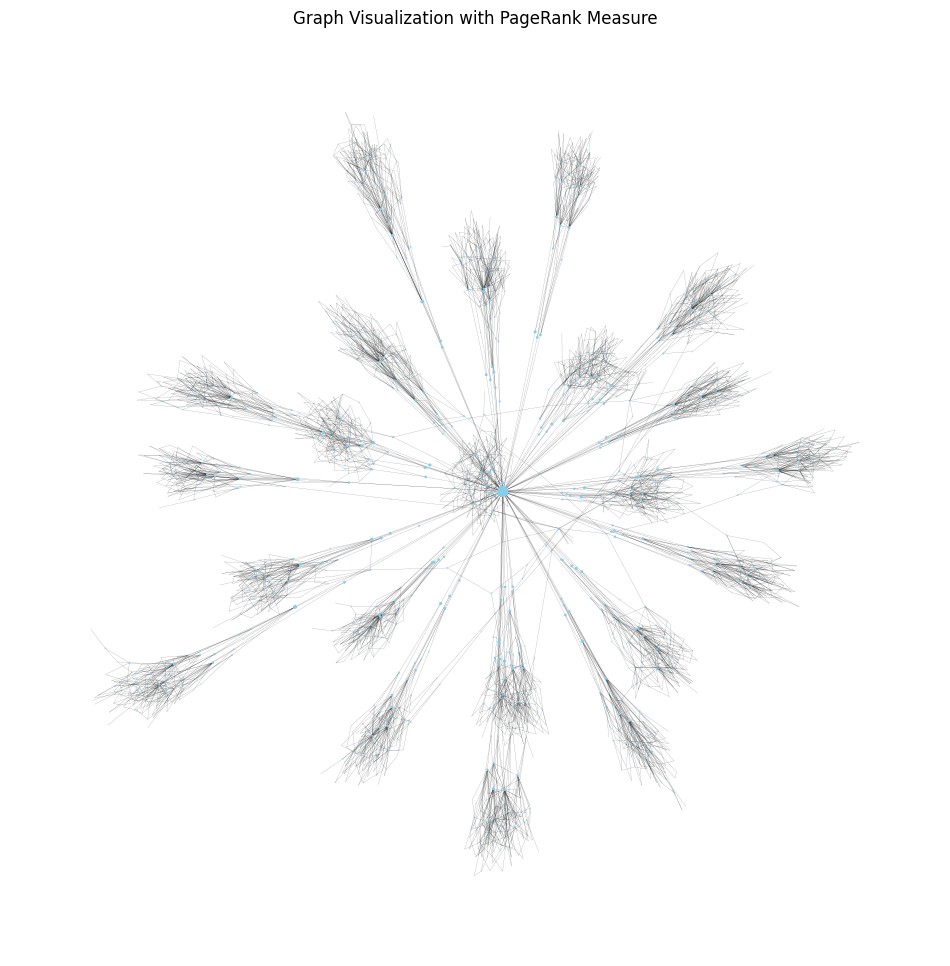

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 50 for v in betweenness_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

### Structural Holes (Trash?)

In [65]:
def structural_holes(G):
    holes = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        internal_connections = len(neighbors)
        external_connections = len(set(G.nodes()) - neighbors)
        holes[node] = external_connections - internal_connections
    return holes

# Apply functions
holes = structural_holes(G_sampled)

print("Structural Holes:", holes)

Structural Holes: {1027964931: 5966, 1033371660: 5996, 1020297230: 5984, 1034453008: 5990, 1020461076: 5994, 1070661660: 5986, 1089830952: 5996, 1039335469: 5996, 1002733615: 5996, 1077870641: 5988, 1087733822: 5994, 1087176767: 5994, 1048707138: 5996, 1069350979: 5990, 1016987723: 5996, 1021771859: 5996, 1072922713: 5996, 1042120794: 5996, 1000243305: 5998, 1043333226: 5982, 1070530675: 5988, 1003192439: 5996, 1049591931: 5990, 1014923387: 5994, 1088290947: 5996, 1074725004: 5994, 1007845520: 5996, 1037467817: 5986, 1061486774: 5988, 1083244727: 5994, 1045692606: 5992, 1038713024: 5996, 1099235537: 5996, 1072398557: 5994, 1086390500: 5994, 1078395110: 5990, 1077018855: 5990, 1041301751: 5996, 1076297976: 5996, 1023836413: 5996, 1086128383: 5996, 1075151104: 5990, 1089732882: 5990, 1079378202: 5998, 1017217310: 5994, 1052442911: 5994, 1078952231: 5992, 1006403884: 5992, 1099923757: 5986, 1086849327: 5992, 1030160693: 5996, 1083244854: 5996, 1027342648: 5986, 1079345482: 5990, 101099143

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph and `holes` is the structural holes dictionary
holes_values = list(holes.values())

# Create mappable for colorbar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=plt.Normalize(vmin=min(holes_values), vmax=max(holes_values)))

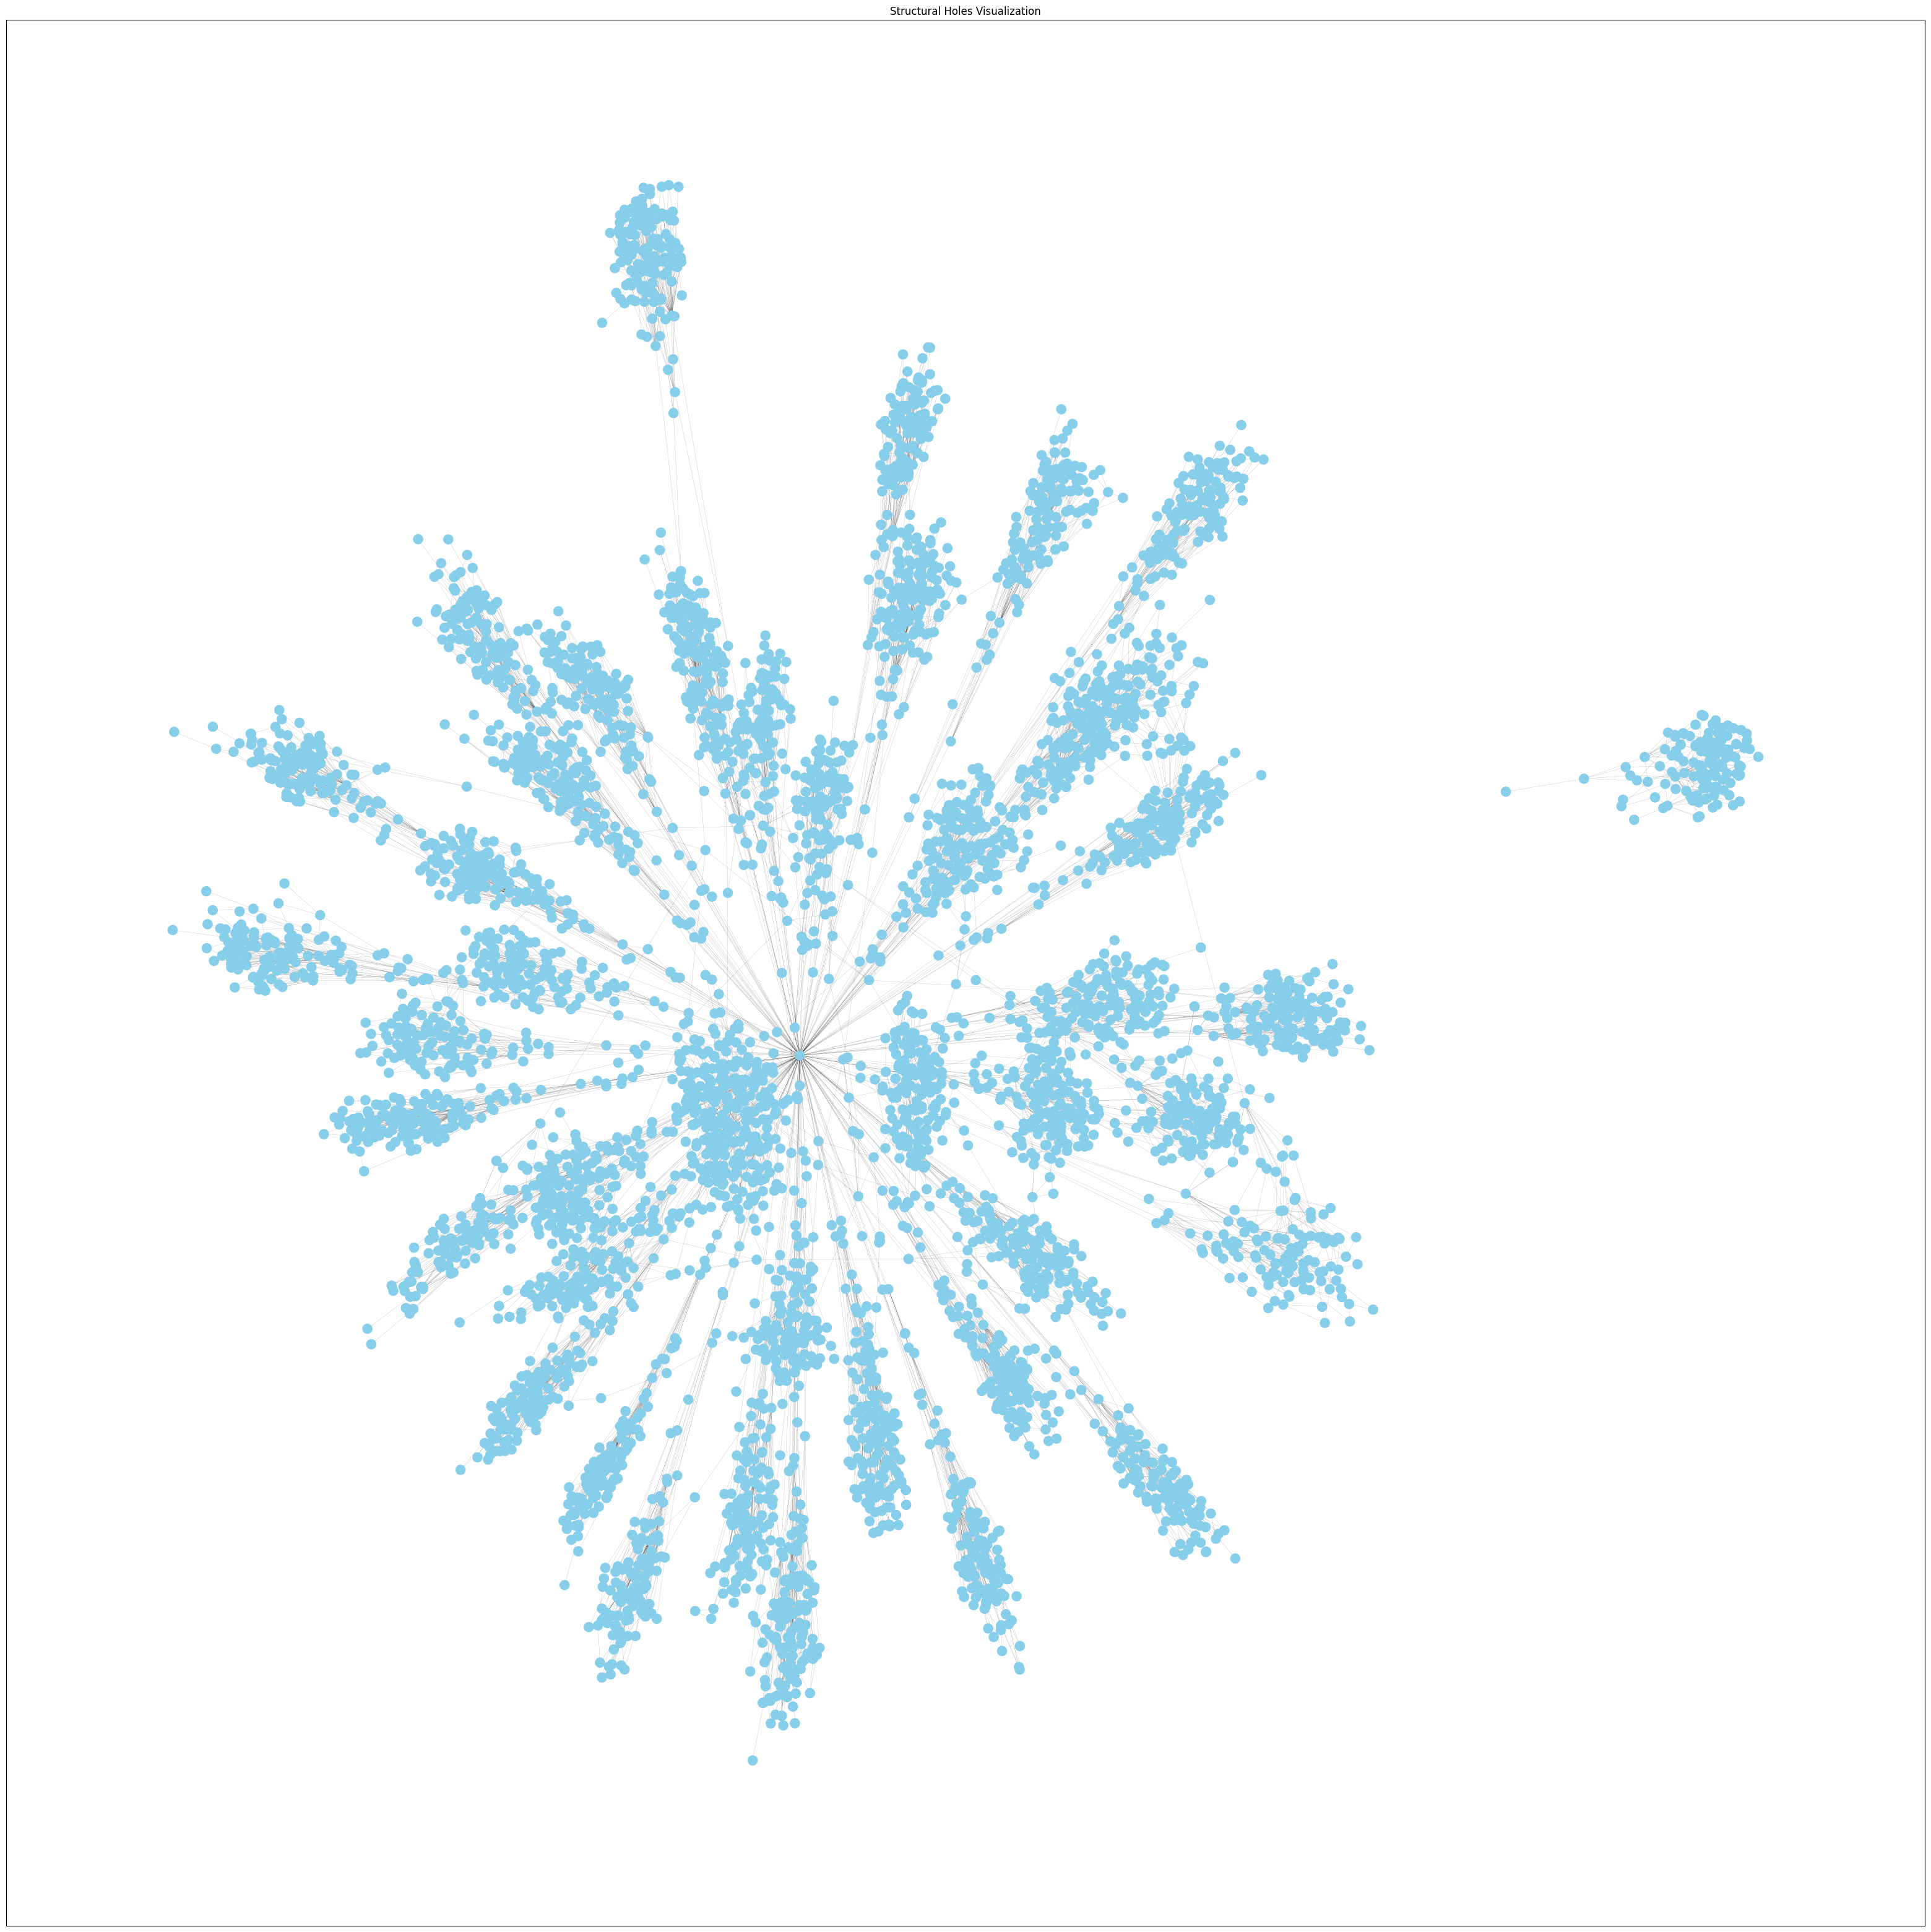

In [68]:
fig = plt.subplots(figsize=(40, 40))
#nx.draw(G_sampled, pos, with_labels=False, node_size=0.02, width=0.05, node_color=holes_values, cmap=plt.cm.RdYlBu)
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 0.02 for v in holes.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Add colorbar
#fig.colorbar(mappable, ax=ax, label='Structural Holes Score')
plt.title('Structural Holes Visualization')
plt.show()

In [69]:
print(holes_values)

[5966, 5996, 5984, 5990, 5994, 5986, 5996, 5996, 5996, 5988, 5994, 5994, 5996, 5990, 5996, 5996, 5996, 5996, 5998, 5982, 5988, 5996, 5990, 5994, 5996, 5994, 5996, 5986, 5988, 5994, 5992, 5996, 5996, 5994, 5994, 5990, 5990, 5996, 5996, 5996, 5996, 5990, 5990, 5998, 5994, 5994, 5992, 5992, 5986, 5992, 5996, 5996, 5986, 5990, 5996, 5992, 5970, 5996, 5996, 5994, 5982, 5996, 5996, 5986, 5994, 5994, 5990, 5996, 5996, 5996, 5952, 5996, 5994, 5994, 5996, 5996, 5994, 5996, 5996, 5986, 5996, 5994, 5988, 5992, 5996, 5986, 5992, 5996, 5996, 5992, 5996, 5996, 5990, 5978, 5994, 5996, 5996, 5996, 5980, 5996, 5996, 5994, 5996, 5996, 5996, 5994, 5976, 5996, 5908, 5988, 5994, 5992, 5996, 5968, 5994, 5996, 5994, 5996, 5992, 5990, 5996, 5922, 5946, 5996, 5992, 5996, 5996, 5992, 5962, 5996, 5986, 5994, 5996, 5996, 5988, 5996, 5992, 5996, 5994, 5996, 5994, 5990, 5994, 5996, 5996, 5960, 5990, 5994, 5994, 5994, 5996, 5994, 5996, 5996, 5992, 5946, 5994, 5984, 5996, 5990, 5978, 5996, 5996, 5982, 5986, 5956, 599